<a href="https://colab.research.google.com/github/sgparrot/sgparrot-2021-spring-session-nlp/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# wget을 활용해서 bert 모델 다운로드 가능
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2021-05-19 04:45:50--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c01::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M  97.0MB/s    in 7.4s    

2021-05-19 04:45:58 (85.9 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
!pip install keras-transformer==0.32.0
!pip install keras-bert==0.81.0
!pip install keras-radam==0.15.0

  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp37-none-any.whl size=13266 sha256=9eaf5ef0b6a4d351929819ab6b33c27104637f55c9d06200882ad5a50047d58b
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp37-none-any.whl size=7554 sha256=91b16da64263bba6f910c74384d0d3d8eb762b4e4ae3092c1ccd2df1df9b4d41
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp37-none-any.whl size=15611 sha256=c7dcebc7c3615492da7424ab5c6e2d107bda929613cd7a759569c35d41e328de
  Stored in directory: /root/.cache/pip/wheels/b5/b4/49/0a0c27dcb93c13af02fea254ff51d1a43a924dd4e5b7a7164d
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.14.0-cp37-none-any.whl size=5269 sha256=65868d2fb9d49cb8603ced9ec883ad2e7a6a8ce612

In [ ]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [ ]:
os.listdir('bert')

['vocab.txt',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'bert_config.json',
 'multi_cased_L-12_H-768_A-12',
 'bert_model.ckpt.data-00000-of-00001']

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train/train-전처리한거.csv',
                    encoding='utf-8',index_col=0,header=0,
                    names=['title','singer','songNum','lyrics','genre','ballad',
                           'dance','hiphop','rb','indi','rock','trot','folk'])
test = pd.read_csv('/content/drive/MyDrive/test/test-전처리한거.csv',
                   encoding='utf-8',index_col=0,header=0,
                   names=['title','singer','songNum','lyrics','genre','ballad',
                           'dance','hiphop','rb','indi','rock','trot','folk'])

print(train.shape)
print(test.shape)

(87694, 13)
(10000, 13)


In [ ]:
train.head(2)

,title,singer,songNum,lyrics,genre,ballad,dance,hiphop,rb,indi,rock,trot,folk
0,Maybe (Remember Me),은지원,0,왜 나를 마주보지 못하니아무런 말이라도 해줘야잖니떠난다는 말이 힘드니그럴 너라면 있...,hiphop,0,0,1,0,0,0,0,0
1,정거장,김수희,50420,떠나가면 눈물을 짓고돌아오면 미소를 짓는바람처럼 스쳐 가는수많은 얼굴안녕이라는 인사...,trot,0,0,0,0,0,0,1,0


In [ ]:
SEQ_LEN = 512
BATCH_SIZE = 4
EPOCHS=2
LR=1e-6

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "lyrics"
LABEL_COLUMN = ['ballad','dance','hiphop','rb','indi','rock','trot','folk']

In [ ]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [ ]:
class inherit_Tokenizer(Tokenizer):
  def _tokenize(self, text):
        if not self._cased:
            text = text
            
            text = text.lower()
        spaced = ''
        for ch in text:
            if self._is_punctuation(ch) or self._is_cjk_character(ch):
                spaced += ' ' + ch + ' '
            elif self._is_space(ch):
                spaced += ' '
            elif ord(ch) == 0 or ord(ch) == 0xfffd or self._is_control(ch):
                continue
            else:
                spaced += ch
        tokens = []
        for word in spaced.strip().split():
            tokens += self._word_piece_tokenize(word)
        return tokens

In [ ]:
tokenizer = inherit_Tokenizer(token_dict)

In [ ]:
tokenizer.tokenize("패럿은 서강대학교 데이터 사이언스 학회다.")

['[CLS]',
 '패',
 '##럿',
 '##은',
 '서',
 '##강',
 '##대학교',
 '데',
 '##이터',
 '사',
 '##이',
 '##언',
 '##스',
 '학',
 '##회',
 '##다',
 '.',
 '[SEP]']

In [ ]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        # targets.append(data_df[LABEL_COLUMN].iloc[i].values)
    targets = data_df[LABEL_COLUMN].iloc[:].values.tolist()
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [ ]:
train_x, train_y = load_data(train)
test_x, test_y = load_data(test)

100%|██████████| 10000/10000 [00:17<00:00, 560.62it/s]


In [ ]:
train_x

[array([[  101,  9596,  8982, ..., 11102, 14646,   102],
        [  101,  9138, 16439, ...,     0,     0,     0],
        [  101, 57667, 10133, ...,     0,     0,     0],
        ...,
        [  101,   183, 10237, ..., 10301, 13028,   102],
        [  101,  8898, 41521, ...,   100, 18392,   102],
        [  101,  9638, 87164, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        print(tokenizer.tokenize(data[i]))
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def sentence_load_data(sentences):#sentence는 List로 받는다
           
    data_x = sentence_convert_data(sentences)

    return data_x

In [ ]:
sentence_load_data(["버트 구현이 너무 어렵다.", "언제쯤 모델을 완성할 수 있을까?"])

100%|██████████| 2/2 [00:00<00:00, 818.24it/s]

['[CLS]', '버', '##트', '구', '##현', '##이', '너', '##무', '어', '##렵', '##다', '.', '[SEP]']
['[CLS]', '언', '##제', '##쯤', '모', '##델', '##을', '완', '##성', '##할', '수', '있을', '##까', '?', '[SEP]']


[array([[  101,  9336, 15184, ...,     0,     0,     0],
        [  101,  9548, 17730, ...,     0,     0,     0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
layer_num = 12
model = load_trained_model_from_checkpoint(
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 512)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 512)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 512, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 512, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [ ]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(8, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

In [ ]:
get_bert_finetuning_model(model)

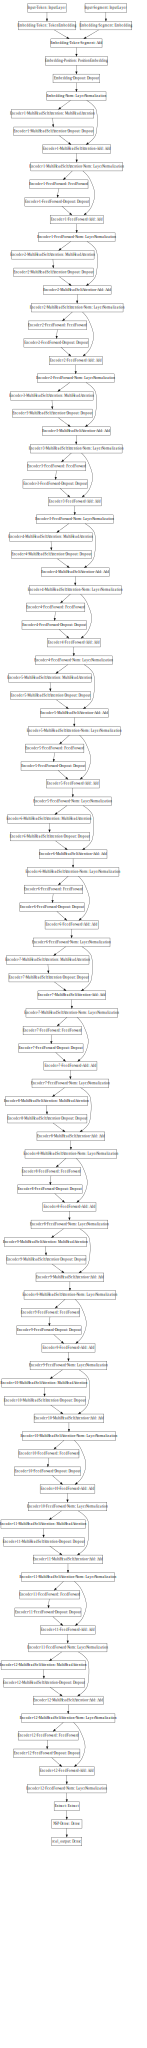

In [ ]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))

In [ ]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=1, batch_size=4, verbose = 1, validation_split=0.1 , shuffle=True)

Train on 78924 samples, validate on 8770 samples
Epoch 1/1
78924/78924 [==============================] - 13734s 174ms/step - loss: 0.2908 - accuracy: 0.8823 - val_loss: 0.2636 - val_accuracy: 0.8893


In [ ]:
bert_model.save_weights('/content/drive/MyDrive/bert.h5')

In [ ]:
bert_model = get_bert_finetuning_model(model)
bert_model.load_weights('/content/drive/MyDrive/bert.h5')

In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data_df))):
        ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data_df = x
    
    
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)


    data_x = predict_convert_data(data_df)

    return data_x

In [ ]:
test_set = predict_load_data(test)

100%|██████████| 10000/10000 [00:17<00:00, 567.20it/s]


In [ ]:
test_set

[array([[   101,   9309,  16985, ...,      0,      0,      0],
        [   101,  78139,  11664, ...,      0,      0,      0],
        [   101,   9952,  35866, ...,      0,      0,      0],
        ...,
        [   101,   8849, 118794, ...,      0,      0,      0],
        [   101,  59381,  10106, ...,      0,      0,      0],
        [   101,   9405,  11018, ...,      0,      0,      0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
#예측
preds = bert_model.predict(test_set)

In [ ]:
preds

array([[0.01056358, 0.0111953 , 0.01486567, ..., 0.03123641, 0.95346737,
        0.03780532],
       [0.00855619, 0.01061177, 0.01107991, ..., 0.03946   , 0.94164824,
        0.04876623],
       [0.01938367, 0.00795344, 0.00474456, ..., 0.02671048, 0.9191339 ,
        0.06902948],
       ...,
       [0.02789408, 0.00673148, 0.0020712 , ..., 0.11337057, 0.46731344,
        0.4464165 ],
       [0.07279626, 0.0512242 , 0.01488966, ..., 0.24871635, 0.0020161 ,
        0.06110272],
       [0.24446231, 0.10960874, 0.04324079, ..., 0.34142056, 0.04282424,
        0.1063455 ]], dtype=float32)

In [ ]:
bert_model.evaluate(test_x, test_y, batch_size=4, verbose=1)

10000/10000 [==============================] - 426s 43ms/step


[0.2614770710125566, 0.8920124769210815]

In [ ]:
preds[0]

array([0.01056358, 0.0111953 , 0.01486567, 0.00713322, 0.0126352 ,
       0.03123641, 0.95346737, 0.03780532], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report


y_true = test[LABEL_COLUMN].values
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))

              precision    recall  f1-score   support

           0       0.62      0.49      0.55      1446
           1       0.85      0.25      0.38      1445
           2       0.74      0.72      0.73      1419
           3       0.63      0.17      0.26      1479
           4       0.76      0.07      0.13      1448
           5       0.65      0.17      0.27      1330
           6       0.80      0.73      0.76       954
           7       0.55      0.21      0.30      1174

   micro avg       0.70      0.34      0.45     10695
   macro avg       0.70      0.35      0.42     10695
weighted avg       0.70      0.34      0.41     10695
 samples avg       0.36      0.35      0.35     10695



In [ ]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    ids, segments = tokenizer.encode(data, max_len=SEQ_LEN)
    indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def genre_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = bert_model.predict(data_x)
    print(predict)

In [ ]:
genre_predict('습관이라는게 정말 무서워 너를 잊을 수 없다는 것 멀리서만 바라본적이 없잖아 너를 잊으려고 한적 없지만 언젠가는 다시 돌아올거라 나는 바랬나봐 너를 보내는 습관을 가져야 한다는것도 잘 알지만 영영 가질수가 있을까 너를 보내는 연습을 난 하지 못했어 이젠 정말 끝인가봐 이제 정말 끝인가봐')

[[0.00948989 0.00568417 0.00825718 0.01189384 0.43471694 0.4501385
  0.01944178 0.48663005]]
